In [130]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from transformers import AutoTokenizer
from evaluate import load
model_folders = 'data/model_comparisons'
tokenizer = AutoTokenizer.from_pretrained('meta-llama/Meta-Llama-3-8B')

cer = load("cer")
wer = load("wer")



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [148]:

model = 'deep_jazz'

all_versions = []

for file in os.listdir(os.path.join(model_folders, model)):

    temp = pd.read_csv(os.path.join(model_folders, model, file))
    temp['file'] = file
    temp['model'] = model
    temp.loc[(temp['cer']==0) & (temp['cer_orig']==0),'erp'] = 1
    temp.loc[np.isinf(temp['erp']),'erp'] = -100

    all_versions.append(temp)


all_versions = pd.concat(all_versions, ignore_index=True)

all_versions['file'] = all_versions['file'].str.replace("BLN_test_recovered_", "").str.replace(".csv", "")

all_versions.sort_values('file', inplace=True)

all_versions['tokens_true'] = all_versions['article_text'].apply(lambda x:len(tokenizer.encode(x)))
all_versions['tokens_raw'] = all_versions['raw_text'].apply(lambda x:len(tokenizer.encode(x)))
all_versions['tokens_output'] = all_versions['output'].apply(lambda x:len(tokenizer.encode(x)))

all_versions['chars_true'] = all_versions['article_text'].apply(len)
all_versions['chars_raw'] = all_versions['raw_text'].apply(len)
all_versions['chars_output'] = all_versions['output'].apply(len)

all_versions['token_char_ratio_true'] = (all_versions['chars_true']-all_versions['tokens_true'])/all_versions['chars_true']
all_versions['token_char_ratio_raw'] = (all_versions['chars_raw']-all_versions['tokens_raw'])/all_versions['chars_raw']
all_versions['token_char_ratio_output'] = (all_versions['chars_output']-all_versions['tokens_output'])/all_versions['chars_output']

all_versions['cer_diff'] = all_versions['cer_orig'] - all_versions['cer']

In [132]:
all_versions.loc[(all_versions['file']=='486') & (all_versions['erp']<0),:].sort_values('erp')[['article_text','raw_text', 'output', 'erp', 'cer', 'cer_orig']].to_csv('./data/bad_conversion_results.csv')

In [133]:
row_number = 3606

In [134]:
all_versions.loc[row_number, 'raw_text']

'The publican, hearing the noise, put them out of the room, when, passing the bar, they attacked each other with. their knives, and continued to do so outside.'

In [135]:
all_versions.loc[row_number, 'output']

'The publican, hearing the noise, put them out of the room, when, passing the bar, they attacked each other with their knives, and continued to do so outside.'

In [136]:
all_versions.loc[row_number, 'article_text']

'The publican, hearing the noise, put them out of the room, when, passing the bar, they attacked each other with their knives, and continued to do so outside.'

In [137]:
all_versions.groupby('file')[['cer', 'erp']].describe()

cer                                               \
                          count      mean       std  min       25%       50%   
file                                                                           
162                      2792.0  0.179705  2.670398  0.0  0.000000  0.000000   
324                      2792.0  0.110174  1.324361  0.0  0.000000  0.000000   
486                      2792.0  0.084774  0.660571  0.0  0.000000  0.000000   
ncse_test_recovered_486    91.0  0.522402  1.218885  0.0  0.047331  0.332855   

                                                  erp                       \
                              75%         max   count      mean        std   
file                                                                         
162                      0.031969  107.000000  2792.0 -0.535307  10.523969   
324                      0.032542   47.581395  2792.0 -0.352781   9.858573   
486                      0.033333   26.000000  2792.0 -0.138755   8.355918   
ncse_test_recovered_486  0.588877   10.244970    91.0 -0.768978   3.328975   

                                                                       
                                min       25%       50%      75%  max  
file                                                                   
162                     -120.270270  0.500000  1.000000  1.00000  1.0  
324                     -165.750000  0.466667  1.000000  1.00000  1.0  
486                     -100.000000  0.461538  1.000000  1.00000  1.0  
ncse_test_recovered_486  -18.401015  0.000016  0.138021  0.38456  1.0

In [138]:
all_versions[all_versions['file']=='486'][['token_char_ratio_true', 'token_char_ratio_raw', 'token_char_ratio_output']].describe()

,token_char_ratio_true,token_char_ratio_raw,token_char_ratio_output
count,2792.000000,2792.000000,2792.000000
mean,0.741555,0.710076,0.741830
std,0.070250,0.085952,0.069518
min,0.000000,0.000000,0.000000
25%,0.732668,0.691036,0.732558
50%,0.761905,0.736842,0.761503
75%,0.781250,0.761905,0.780952
max,0.854545,0.839506,0.854545


<Axes: xlabel='erp', ylabel='cer_diff'>

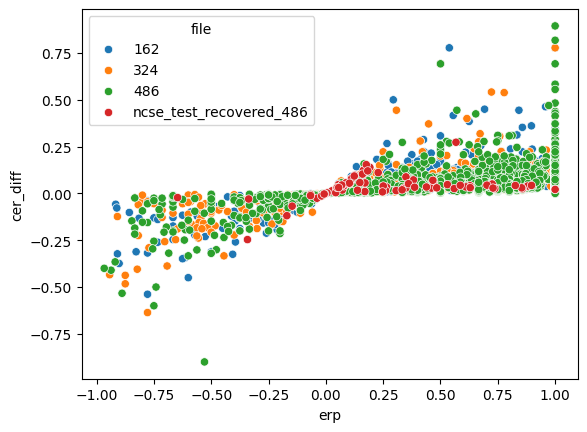

In [149]:
sns.scatterplot(data = all_versions.loc[(all_versions['cer']<10) & (all_versions['erp']>-1)] , x = 'erp', y = 'cer_diff', hue = 'file')

In [156]:
0.59*500 +0.79*450

650.5

In [140]:
sum(all_versions['erp']>0)/all_versions.shape[0]

0.8438644147868194

<Axes: xlabel='value', ylabel='Density'>

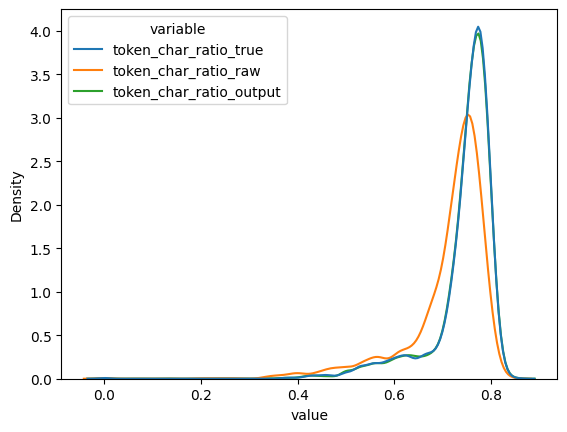

In [141]:
sns.kdeplot(data = all_versions.loc[:, ['token_char_ratio_true', 'token_char_ratio_raw', 'token_char_ratio_output']].melt(),
            x = 'value', hue = 'variable')

<Axes: xlabel='cer_orig', ylabel='token_char_ratio_raw'>

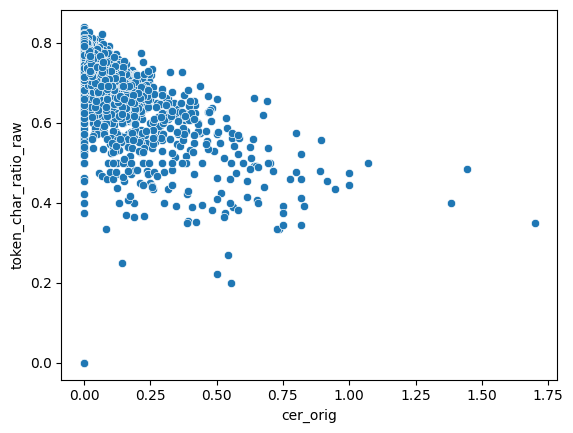

In [142]:
#['cer','token_char_ratio_true', 'token_char_ratio_raw', 'token_char_ratio_output']

sns.scatterplot(data = all_versions.loc[all_versions['file']=='486',:], x = 'cer_orig', y = 'token_char_ratio_raw') 

<Axes: xlabel='tokens_raw', ylabel='tokens_output'>

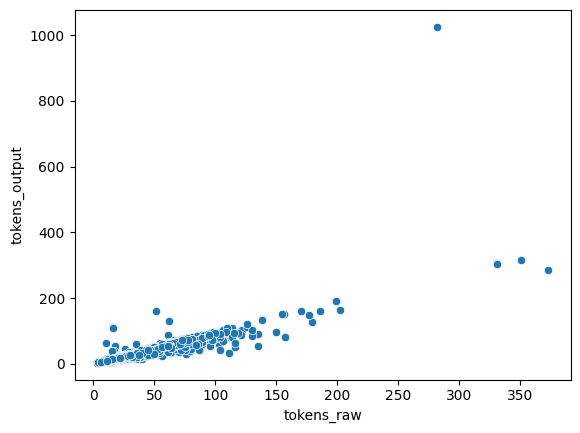

In [143]:
sns.scatterplot(data = all_versions.loc[all_versions['file']=='486',:], x = 'tokens_raw', y = 'tokens_output') 

In [144]:

def pre_evaluation_processing(df, ground_truth_df, post_lm_text, gt_text ):
    df['id'] = df['id'].str.replace('filename_', '')

    df = df.merge(ground_truth_df.set_index('file_name'), left_on = 'id', right_index = True)
    #df['post_lm_text2'] = df['post_lm_text'].apply(extract_first_match)
    df[post_lm_text] = df[post_lm_text].str.replace("\n*", " ").str.lower()
    df[gt_text] = df[gt_text].str.replace("\n*", " ").str.lower()
    df.reset_index(inplace=True)

    return df

def evaluate_model(df, metric_obj, gt_text, post_lm_text):

    """ 
    Uses a huggingface metric to evaluate the results
    """
    
    # Calculate CER for each pair
    results = []
    for index, row in df.iterrows():
        ground_truth_text = row[gt_text]
        response_text = row[post_lm_text]
        result = metric_obj.compute(predictions=[response_text], references=[ground_truth_text])
        results.append(result)

    df['cer'] = results

    return df


In [145]:
from evaluation_funcs import load_txt_files_to_df

corrected_transcript_oct_folder = "./data/transcripts/transcription_files"

corrected_gold_ocr_df = load_txt_files_to_df(corrected_transcript_oct_folder)

raw_ocr_df = load_txt_files_to_df("./data/transcripts/transcription_raw_ocr")
raw_ocr_df = raw_ocr_df.rename(columns={'article_text':'post_lm_text', 'file_name':'id'})

corrected_gold_ocr_df = pre_evaluation_processing(raw_ocr_df, corrected_gold_ocr_df, post_lm_text= 'post_lm_text', gt_text = 'article_text' )
corrected_gold_ocr_df = evaluate_model(df = corrected_gold_ocr_df, metric_obj = cer, gt_text = 'article_text', post_lm_text = 'post_lm_text')
corrected_gold_ocr_df.rename(columns = {'cer':'cer_orig', 'id':'file_name'}, inplace=True)
corrected_gold_ocr_df.drop(columns=['index', 'post_lm_text'], inplace=True)

corrected_gold_ocr_df

,file_name,article_text,cer_orig
0,artid_841530_periodical_ns_issue_vm2-ncseprodu...,"monomania.\n\nsince oxford ""popped"" at the que...",0.052256
1,artid_751411_periodical_pc_issue_tec_01051889_...,‘the plague and the printing press: being a bi...,0.481586
2,artid_871466_periodical_ns_issue_ns2_02101852_...,"he performed upon diverse of the foremost, who...",0.044863
3,artid_494321_periodical_ewj_issue_ewj_01051860...,having to tramp into some dirty court in searc...,0.151261
4,artid_495935_periodical_ewj_issue_ewj_01011860...,tomorrow we are going to pillage the archbisho...,0.123429
...,...,...,...
86,artid_841528_periodical_ns_issue_vm2-ncseprodu...,because too much power was placed in the hands...,0.060137
87,artid_766218_periodical_pc_issue_tec_01031886_...,"electrotypes. \nmessrs. sampson low, marston, ...",0.753086
88,artid_771187_periodical_pc_issue_tec_15091890_...,books and rumours of books\n\nmiss braddon's n...,0.696710
89,artid_653700_periodical_mruc_issue_vm2-ncsepro...,have been designed: there may therefore be the...,0.061052


In [146]:
corrected_transcript_oct_folder = "./data/transcripts/transcription_files"

corrected_gold_ocr_df = load_txt_files_to_df(corrected_transcript_oct_folder)

corrected_gold_ocr_df['article_text'] = corrected_gold_ocr_df['article_text'].str.replace("\n", " ")

corrected_gold_ocr_df['tokens'] = corrected_gold_ocr_df['article_text'].apply(lambda x:len(tokenizer.encode(x)))

In [147]:
sum(corrected_gold_ocr_df['tokens']>2000)



3